In [1]:
'''
# Colab Setting 
# Google Drive Access Authorization  
from google.colab import drive
drive.mount('/content/gdrive/')

# Path Setting
path = "/content/gdrive/My Drive/cifar-10/"
'''

'\n# Colab Setting \n# Google Drive Access Authorization  \nfrom google.colab import drive\ndrive.mount(\'/content/gdrive/\')\n\n# Path Setting\npath = "/content/gdrive/My Drive/cifar-10/"\n'

In [7]:
filepath = 'D:/Google Drive/cifar-10/'

In [3]:
import torch
import torch.nn.functional as F
from torchvision import datasets,transforms
import torch.nn as nn

In [4]:
# SEED SETTING 
import random
import os 
import numpy as np

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

SEED = 0
seed_everything(SEED)

In [624]:
import pandas as pd 
from torch.utils.data import Dataset as BaseDataset
from PIL import Image
import albumentations as A
from torch.autograd import Variable


class CIFARDataset(BaseDataset):
    def __init__(self, path, transform = False, train=True):
        """
        train_files : train file list 
        is_test_or_not : test or not 
        is_transform : True augmentation 
        """
        self.path = path
        self.train = train
        
        if train:
            self.labels = pd.read_csv(filepath + 'trainLabels.csv')

            # labels의 값이 문자열로 되어있기에 수치형으로 변경 
            self.class2idx = {}
            for i, j in enumerate(self.labels['label'].unique()):
                self.class2idx[j] = i

            self.idx2class = {}
            for i, j in self.class2idx.items():
                self.idx2class[j] = i

            self.labels['label'] = self.labels['label'].apply(lambda x: self.class2idx[x])
        else:
            self.labels = pd.read_csv(filepath + 'sampleSubmission.csv')
            
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # 이미지가 있는 파일의 경로를 설정하고 불러올 이미지의 이름을 저장 (id가 1번인 이미지의 파일명은 1.jpg)
        img_name = self.path + str(self.labels.iloc[idx, 0])
        # 이미지를 열어서 
        image_file = Image.open(img_name + '.png')

        if self.transform:
            torchvision_transform = transforms.Compose([
                transforms.Resize((32, 32)), 
                # transforms.RandomCrop(224),
                # transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])
            ])
            image_file = torchvision_transform(image_file)
        else:
            torchvision_transform = transforms.Compose([
                transforms.Resize((32, 32)), 
                # transforms.RandomCrop(224),
                # transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])
            ])
            image_file = torchvision_transform(image_file)
            
        if self.train:
            label = self.labels.iloc[idx, 1]
            return image_file, label
        else:
            return image_file

In [625]:
from torch.utils.data import Dataset, DataLoader

train_loader = DataLoader(CIFARDataset(filepath + 'train/', transform = True), batch_size=64, shuffle=True, num_workers=0)

In [594]:
class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels = 3,
                                        out_channels = 64,
                                        kernel_size = 3,
                                        stride = 1,
                                        padding = 1),
                            nn.BatchNorm2d(64),
                            nn.ReLU())
        
        self.layer2 = nn.Sequential(nn.Conv2d(in_channels = 64,
                                        out_channels = 128,
                                        kernel_size = 3,
                                        stride = 1,
                                        padding = 1),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        self.layer3 = nn.Sequential(nn.Conv2d(in_channels = 128,
                                        out_channels = 128,
                                        kernel_size = 3,
                                        stride = 1,
                                        padding = 1),
                            nn.ReLU())

        self.layer4 = nn.Sequential(nn.Conv2d(in_channels = 128,
                                        out_channels = 128,
                                        kernel_size = 3,
                                        stride = 1,
                                        padding = 1),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size = 2, stride = 2), 
                            )   
        
        # 32 -> max pooling 2 times -> 8 
        self.layer5 = nn.Flatten()
    
        self.layer6 = nn.Sequential(nn.Linear(8 * 8 * 128, 256),
                            nn.ReLU(),
                            nn.Dropout(0.5))
                  
        self.layer7 = nn.Sequential(nn.Linear(256, 256),
                            nn.ReLU()
                            )
              
        self.fc = nn.Linear(256, 10)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.fc(x)
        return x

In [ ]:
dev = torch.cuda.set_device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [574]:
# We need to convert the images to numpy arrays as tensors are not compatible with matplotlib.
def im_convert(tensor):  
    image = tensor.cpu().clone().detach().numpy() # This process will happen in normal cpu.
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

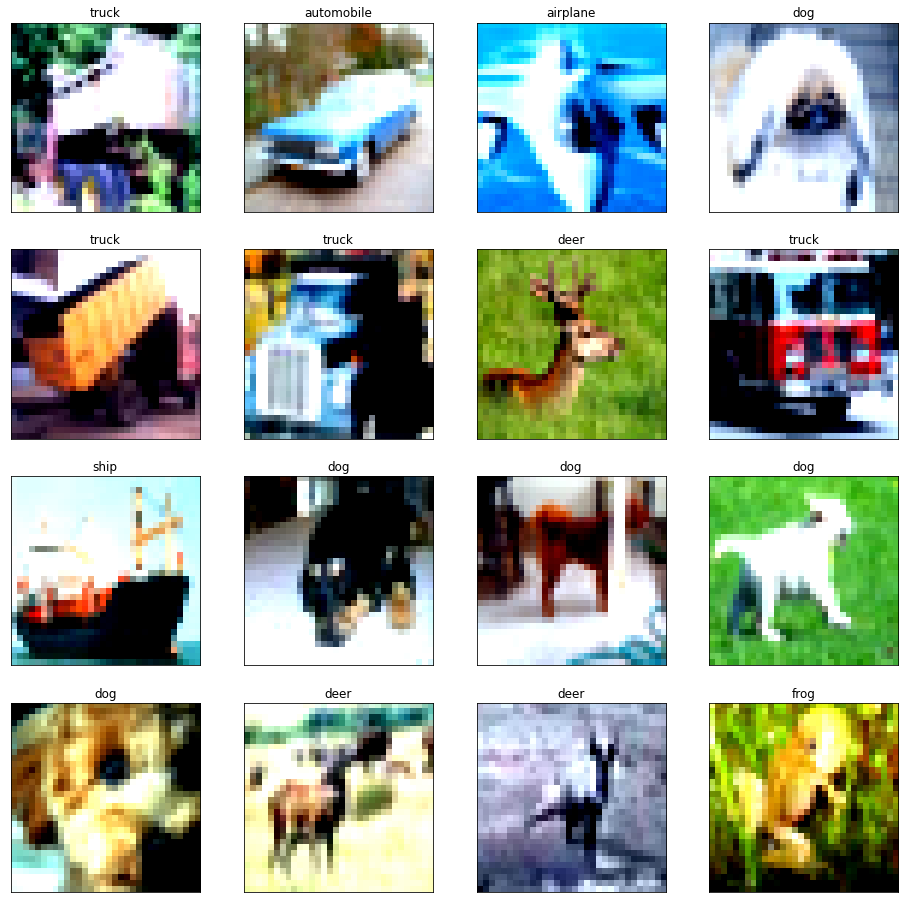

In [575]:
from matplotlib import pyplot as plt

# We iter the batch of images to display
dataiter = iter(train_loader) # converting our train_dataloader to iterable so that we can iter through it. 
images, labels = dataiter.next() #going from 1st batch of 16*16 images to the next batch
fig = plt.figure(figsize=(16, 16)) 

# We plot 16 images from our train_dataset
for idx in np.arange(16):
    ax = fig.add_subplot(4, 4, idx+1, xticks=[], yticks=[]) 
    plt.imshow(im_convert(images[idx])) #converting to numpy array as plt needs it.
    ax.set_title(train_loader.dataset.idx2class[labels[idx].item()])

In [599]:
from torch import optim

model = DeepCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
from tqdm.notebook import tqdm as tqdm_notebook

nb_epochs = 50
train_losses = []
train_accuracy = []
# test_losses = []

for epoch in tqdm_notebook(range(0, nb_epochs)):
    train_loss = 0
    correct = 0
    best_valid = 0
    
    for idx, (train_batch, label) in enumerate(train_loader):
        # Variable : 자동 미분을 도와주는 도구 
        train_batch, label = Variable(train_batch).to(dev), Variable(label).to(dev)
        optimizer.zero_grad()
        
        prediction = model(train_batch)
        loss = criterion(prediction, label)    
        loss.backward()
        train_loss += loss.item() 
        optimizer.step()
        
        _, predicted = torch.max(prediction, 1)
        correct += (predicted == label).sum()

    if epoch % 1 == 0: 
        print('Epoch {:4d}/{} Train Loss: {:.6f} Train Accuracy: {:.6f}'.format(epoch+1, nb_epochs, train_loss, correct.detach().numpy() / len(train_loader.dataset)))
        train_losses.append(train_loss)
        train_accuracy.append(correct.detach().numpy() / len(train_loader.dataset))

    # 모델의 스코어가 가장 높은 모델을 저장 
    # 단, 원래는 Validation set으로 진행해야 하지만 분석의 편의상 Train으로 진행 
    if (best_valid == None or best_valid < correct.detach().numpy() / len(train_loader.dataset)):
            best_valid = correct.detach().numpy() / len(train_loader.dataset)
            torch.save(model, filepath + 'savedmodel/cifar10-cnn_v1.pth')

In [644]:
test_dataloader = DataLoader(CIFARDataset(filepath + 'test/', transform = False, train=False), batch_size=1, shuffle=False, num_workers=0)

best_model = torch.load(filepath + f'savedmodel/cifar10-cnn_v1.pth')
best_model.eval()
results = []
for batch_idx, (feature, _) in tqdm_notebook(enumerate(test_dataloader)):
    # 32*32 : image size 
    with torch.no_grad():
        predict = best_model(feature.to(dev))
        _, predict = torch.max(predict, 1)
    results.append(train_loader.dataset.idx2class[predict.detach().numpy()[0]])

In [648]:
sampleSubmission = pd.read_csv(filepath + 'sampleSubmission.csv')
sampleSubmission['label'] = results
sampleSubmission.to_csv(filepath + "submission.csv", index=False)